In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saksh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saksh\AppData\Roaming\nltk_data...


[nltk_data]   Package wordnet is already up-to-date!


True

#### Dataset

In [3]:
data = pd.read_csv('../datasets/mail_data.csv')
print(data.head())
print(data.shape)

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)


#### Data Preprocessing

In [4]:
data.isnull().any()

Category    False
Message     False
dtype: bool

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = text.lower()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
  return text

In [6]:
X = data['Message'].apply(preprocess_text)

In [7]:
X

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts st ...
3                     u dun say early hor u c already say
4                     nah think go usf life around though
                              ...                        
5567    nd time tried contact u u pound prize claim ea...
5568                            b going esplanade fr home
5569                                 pity mood suggestion
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: Message, Length: 5572, dtype: object

In [8]:
y = data['Category'].map({'ham': 0, 'spam': 1})

In [9]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: Category, Length: 5572, dtype: int64

#### Train-test-split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### BOW

In [11]:
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.9)


X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [12]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 32274 stored elements and shape (4457, 1790)>

In [13]:
print("Original class distribution:", Counter(y_train))

Original class distribution: Counter({0: 3859, 1: 598})


#### SMOTE

In [14]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)


print("Resampled class distribution:", Counter(y_train_resampled))

Resampled class distribution: Counter({1: 3859, 0: 3859})


#### Model

In [15]:
model = MultinomialNB(alpha=0.1, fit_prior=True)
model.fit(X_train_resampled, y_train_resampled)


y_pred = model.predict(X_test_tfidf)

Accuracy: 96.68%
Classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       966
           1       0.86      0.89      0.88       149

    accuracy                           0.97      1115
   macro avg       0.92      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



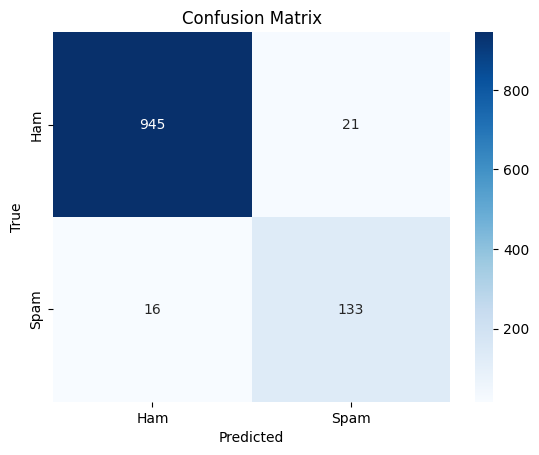

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')


print(f'Classification report\n{classification_report(y_test, y_pred)}')


conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Hyperparameter tuning

In [17]:
param_grid = {'alpha': [0.1, 0.5, 1.0], 'fit_prior': [True, False]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'alpha': 0.1, 'fit_prior': True}


#### Cross-validation

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=skf)
print(f'Cross-validation scores with StratifiedKFold: {cv_scores}')

Cross-validation scores with StratifiedKFold: [0.84779793 0.86852332 0.85816062 0.85936487 0.96759559]


#### New data

In [19]:
def predict_new_data(new_data):
    new_data_processed = [preprocess_text(text) for text in new_data]
    new_data_tfidf = vectorizer.transform(new_data_processed)
    return model.predict(new_data_tfidf)

In [20]:
predict_new_data(['free free 1 million dollar lottery, claim now', 'Important meeting at 3pm'])

array([1, 0])

#### Saving the model

In [21]:
joblib.dump(model, 'spam_classifier.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']